In [1]:
import numpy as np
import pandas as pd

In [2]:
def calcShannonEnt(dataSet):
    '''
    计算香农熵
    :param dataSet : 数据集
    :return        : 计算结果
    '''
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: # 遍历每个实例，统计标签的频数，学习：频数统计
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0 #创建key
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * np.math.log(prob,2) # 以2为底的对数，学习：python中求和符号的另一种写法
    return shannonEnt

In [3]:
def calcGini(dataSet):
    '''
    计算基尼值
    :param dataSet : 数据集
    :return        : 计算结果
    '''
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: # 遍历每个实例，统计标签的频数，学习：频数统计
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0 #创建key
        labelCounts[currentLabel] += 1
    Gini = 1.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * prob # 以2为底的对数，学习：python中求和符号的另一种写法
    return Gini

In [4]:
def splitDataSet(dataSet, axis, value):
    '''
    按照给定特征的具体取值划分数据集
    :param dataSet : 待划分的数据集
    :param axis    : 划分数据集的特征
    :param value   : 需要返回的特征的值
    :return        : 划分结果列表
    '''
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:              #判断样本对应维度上的特征值是否等于所需划分的值，等于则归入这一子类
            reducedFeatVec = featVec[:axis]     #把样本加入子数据集，剔除所用划分维度对应的数据（未来不再作为划分候选）
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet #一个子数据集，所用划分维度上的取值都是相同的

In [5]:
# def calcConditionalEntropy(dataSet, i, featList, uniqueVals):
def calcConditionalEntropy(dataSet, i, uniqueVals):
    '''
    计算X_i给定的条件下，Y的条件熵
    :param dataSet    : 数据集
    :param i          : 维度i
    :param uniqueVals : 数据集特征集合
    :return           : 条件熵
    '''
    conditionEnt = 0.0
    for value in uniqueVals: #遍历这一特征下所有的特征值进行划分
        subDataSet = splitDataSet(dataSet, i, value)
        prob = len(subDataSet) / float(len(dataSet))  # 极大似然估计概率
        conditionEnt += prob * calcShannonEnt(subDataSet)  # 条件熵的计算
    return conditionEnt

In [6]:
def calcGini_index(dataSet, i):
    '''
    计算X_i给定的条件下，Y的基尼指数
    :param dataSet    : 数据集
    :param i          : 维度i
    :return           : 基尼指数
    '''
    featList = [example[i] for example in dataSet]  # 第i维特征的取值列表，学习：快速获取DataSet中对应一列（一种特征）全部取值的方法
    uniqueVals = set(featList)                      # 转换成集合，去重，获得了这个DataSet在第i特征值上的所有取值情况
    Gini_index = 1.0
    for value in uniqueVals: #遍历这一特征下所有的特征值进行划分
        subDataSet = splitDataSet(dataSet, i, value)
        prob = len(subDataSet) / float(len(dataSet))  # 极大似然估计概率
        Gini_index -= prob * prob  # 基尼指数的计算
    return Gini_index

In [7]:
def calcInformationGain(dataSet, baseEntropy, i):
    '''
    计算信息增益
    :param dataSet      : 数据集
    :param baseEntropy  : 数据集的信息熵
    :param i            : 特征维度i
    :return             : 特征i对数据集的信息增益g(D|X_i)
    '''
    featList = [example[i] for example in dataSet]  # 第i维特征列表，学习：快速获取DataSet中对应一列（一种特征）全部取值的方法
    uniqueVals = set(featList)  # 转换成集合，去重，获得了这个DataSet在第i特征值上的所有取值情况
    # newEntropy = calcConditionalEntropy(dataSet, i, featList, uniqueVals)
    newEntropy = calcConditionalEntropy(dataSet, i, uniqueVals)
    infoGain = baseEntropy - newEntropy  # 信息增益，就yes熵的减少，也就yes不确定性的减少
    return infoGain

In [8]:
def calcIV(dataSet, i):
    '''
    计算固有值IV
    :param dataSet      : 数据集
    :param i            : 特征维度i
    :return             : 特征i对数据集的固有值IV（intrinsic value）
    '''
    featureiCnt = {}
    featList = [example[i] for example in dataSet]
    numEntries = len(dataSet)
    for vote in featList:
        if vote not in featureiCnt.keys():
            featureiCnt[vote] = 0
        featureiCnt[vote] += 1
    IV_i = 0.0
    for key in featureiCnt:
        prob = float(featureiCnt[key]) / numEntries
        IV_i -= prob * np.math.log(prob,2)  # IV作为分母值，会出现等于0的情况（该数据集下该特征均取同一个特征值），但会首先被信息增益大于均值剔除
    return IV_i 

In [9]:
def calcInformationGainRatio(dataSet, baseEntropy, i):
    '''
    计算信息增益率
    :param dataSet      : 数据集
    :param baseEntropy  : 数据集的信息熵
    :param i            : 特征维度i
    :return             : 特征i对数据集的信息增益比gR(D|X_i)
    '''
    return calcInformationGain(dataSet, baseEntropy, i) / calcIV(dataSet, i)

In [10]:
def chooseBestFeatureToSplitByID3(dataSet):
    '''
    选择最好的数据集划分方式 ID3算法
    :param dataSet   : 数据集
    :return          : 划分结果，最优特征的维度
    '''
    numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征向量，计算得到特征总个数（即X的维数）
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):  # 遍历所有特征
        infoGain = calcInformationGain(dataSet, baseEntropy, i)     # 计算信息增益
        if (infoGain > bestInfoGain):  # 选择最大的信息增益
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature  # 返回最优特征对应的维度

In [11]:
def chooseBestFeatureToSplitByC45(dataSet):
    '''
    选择最好的数据集划分方式 C4.5算法
    :param dataSet   : 数据集
    :return          : 划分结果，最优特征的维度
    '''
    numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征向量，计算得到特征总个数（即X的维数）
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGainRatio = 0.0
    bestFeature = -1
    SuminfoGain = 0.0
    for i in range(numFeatures):                                               # 遍历所有特征
        infoGain = calcInformationGain(dataSet, baseEntropy, i)                # 计算信息增益
        SuminfoGain += infoGain                                                # 求和用以计算信息增益平均值
    AvginfoGain = SuminfoGain / numFeatures                                    # 计算信息增益平均值
    for i in range(numFeatures):
        infoGain = calcInformationGain(dataSet, baseEntropy, i)                # 计算信息增益
        if (infoGain >= AvginfoGain):                                          # 选择 信息增益高于平均水平 做第一步删选（排除IV=0无意义情况）
            infoGainRatio = calcInformationGainRatio(dataSet, baseEntropy, i)  # 计算信息增益率
            if (infoGainRatio > bestInfoGainRatio):                            # 选择 信息增益率最大 作为最优划分特征
                bestInfoGainRatio = infoGainRatio
                bestFeature = i
    return bestFeature  # 返回最优特征对应的维度

In [12]:
def chooseBestFeatureToSplitByCART(dataSet):
    '''
    选择最好的数据集划分方式 CART算法
    :param dataSet   : 数据集
    :return          : 划分结果，最优特征的维度
    '''
    numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征向量，计算得到特征总个数（即X的维数）
    bestGini_index = 1.0
    bestFeature = -1
    for i in range(numFeatures):
        Gini_index = calcGini_index(dataSet, i)                                # 计算基尼指数
        if (Gini_index < bestGini_index):                                      # 选择最小的基尼指数
            bestInfoGainRatio = Gini_index
            bestFeature = i
    return bestFeature  # 返回最优特征对应的维度

In [13]:
def majorityCnt(classList):
    '''
    采用多数表决的方法决定叶结点的分类，判定递归结束后使用
    :param classList : 所有的类标签列表
    :return          : 出现次数最多的类
    '''
    classCount={}
    for vote in classList:                  # 统计所有类标签的频数，学习：频数统计
        if vote not in classCount.keys():   # 字典的所有键，列表
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True) # 排序，降序
    return sortedClassCount[0][0]

In [14]:
def createTree(dataSet,labels):
    '''
    创建决策树
    :param dataSet  : 训练数据集
    :return labels  : 所有的类标签
    '''
    classList = [example[-1] for example in dataSet] # 学习：快速获取DataSet某一列
    if classList.count(classList[0]) == len(classList): 
        return classList[0]             # 第一个递归结束条件：所有的类标签完全相同
    if len(dataSet[0]) == 1:        
        return majorityCnt(classList)   # 第二个递归结束条件：用完了所有特征
    
#     bestFeat = chooseBestFeatureToSplitByID3(dataSet)   # 最优划分特征 ID3算法
#     bestFeat = chooseBestFeatureToSplitByC45(dataSet)   # 最优划分特征 C4.5算法
    bestFeat = chooseBestFeatureToSplitByCART(dataSet)  # 最优划分特征 CART算法
    
    bestFeatLabel = labels[bestFeat]    # 最优划分特征的名称
    myTree = {bestFeatLabel:{}}         # 使用字典类型储存树的信息
    del(labels[bestFeat])               # 下一轮递归开始前，删去已经使用的特征
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:        # 遍历这个最优特征下的每个取值，每个取值都会对应划分出一个子集
        subLabels = labels[:]       # 复制所有类标签，保证每次递归调用时不改变原始列表的内容
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels) # 这里的myTree[bestFeatLabel][value]对应“最佳划分特征下某个特性取值”这一键对应的值，若下一次递归就结束了，它将是一个字符串，否则还是一个字典继续递归
    return myTree                                                                                   # 这是递归算法的核心所在，重复前一轮操作——判别是否结束、选最优划分特征、划分出子集

In [15]:
import matplotlib.pyplot as plt
# import tree
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="round4", color='#3366FF')  # 定义判断结点形态
leafNode = dict(boxstyle="circle", color='#FF6633')  # 定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='g')  # 定义箭头

#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':# 测试结点的数据类型是否为字典
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

# 计算树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':# 测试结点的数据类型是否为字典
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

# 绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )

# 在父子结点间填充文本信息  
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)  # 计算宽与高
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]      
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  # 标记子结点属性值
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD # 减少y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

{'safety': {'high': {'lug_boot': {'small': {'person': {'2': 'unacc', 'more': {'doors': {'2': 'unacc', '3': {'maint': {'high': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'acc', 'vhigh': 'unacc'}}, 'med': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'good', 'vhigh': 'acc'}}, 'low': {'buying': {'high': 'acc', 'med': 'good', 'low': 'good', 'vhigh': 'acc'}}, 'vhigh': {'buying': {'high': 'unacc', 'med': 'acc', 'low': 'acc', 'vhigh': 'unacc'}}}}, '5more': {'maint': {'high': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'acc', 'vhigh': 'unacc'}}, 'med': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'good', 'vhigh': 'acc'}}, 'low': {'buying': {'high': 'acc', 'med': 'good', 'low': 'good', 'vhigh': 'acc'}}, 'vhigh': {'buying': {'high': 'unacc', 'med': 'acc', 'low': 'acc', 'vhigh': 'unacc'}}}}, '4': {'maint': {'high': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'acc', 'vhigh': 'unacc'}}, 'med': {'buying': {'high': 'acc', 'med': 'acc', 'low': 'good', 'vhigh': 'acc'}}, 'low': {'buyin

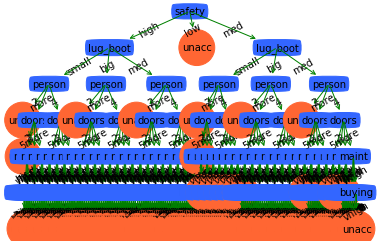

In [29]:
# 导入数据
def createDataSet():
    path = u"C:/Users/jxjsj/Desktop/carEvaluation.txt"
    dataSet_temp = pd.read_csv(path, header = None)
    dataSet = np.array(dataSet_temp).tolist()
    labels = ["buying","maint","doors","person","lug_boot","safety"]
#     dataSet = [['youth', 'no', 'no', '1', 'refuse'],
#                ['youth', 'no', 'no', '2', 'refuse'],
#                ['youth', 'yes', 'no', '2', 'agree'],
#                ['youth', 'yes', 'yes', '1', 'agree'],
#                ['youth', 'no', 'no', '1', 'refuse'],
#                ['mid', 'no', 'no', '1', 'refuse'],
#                ['mid', 'no', 'no', '2', 'refuse'],
#                ['mid', 'yes', 'yes', '2', 'agree'],
#                ['mid', 'no', 'yes', '3', 'agree'],
#                ['mid', 'no', 'yes', '3', 'agree'],
#                ['elder', 'no', 'yes', '3', 'agree'],
#                ['elder', 'no', 'yes', '2', 'agree'],
#                ['elder', 'yes', 'no', '2', 'agree'],
#                ['elder', 'yes', 'no', '3', 'agree'],
#                ['elder', 'no', 'no', '1', 'refuse'],
#                ]
    
#     dataSet = [
#                 [0, 0, 0, 0,1,0 ,0],
#                 [0, 0, 0, 1,1,0 ,0],
#                 [0, 1, 0, 1,0,1 ,1],
#                 [0, 1, 1, 0,1,0 ,1],
#                 [0, 0, 0, 0,0,0 ,0],
#                 [1, 0, 0, 0,1,0 ,0],
#                 [1, 0, 0, 1,1,0 ,0],
#                 [1, 1, 1, 1,0,1 ,1],
#                 [1, 0, 0, 2,1,0 ,1],
#                 [1, 0, 1, 2,1,1 ,1],
#                 [2, 0, 0, 2,0,0 ,1],
#                 [2, 0, 0, 1,1,1 ,1],
#                 [2, 1, 0, 1,0,0 ,1],
#                 [2, 1, 0, 2,1,1 ,1],
#                 [2, 0, 0, 0,0,0 ,0],
#                 ]

#     labels = ['age', 'working?', 'house?', 'credit_situation']
    
#     labels = ['Age','Work?','House?','Credit?','Married?','Drink?']
    
    return dataSet, labels
# 测试代码
if __name__ == "__main__":
    myDat, labels = createDataSet()
    myTree = createTree(myDat, labels)
    print(myTree)
    createPlot(myTree)

In [30]:
def classify(inputTree,featLabels,testVec):
    '''
    利用决策树进行分类
    :param inputTree  : 构造好的决策树模型
    :param featLabels : 所有的类标签
    :param testVec    : 测试数据
    :return           : 分类决策结果
    '''
    firstStr = list(inputTree.keys())[0]         # 获取决策的分支特征
    secondDict = inputTree[firstStr]       # 获取该分支特征
    featIndex = featLabels.index(firstStr) # 获取该特征的维度数，学习：列表的值对应的索引快速获取方式
    key = testVec[featIndex]               # 获取测试样本在该维度下的取值
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict):      # 判断该键下对应是否是一个字典，若是，说明树还未到叶节点，递归
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [38]:
classify(myTree,['Age','Work?','House?','Credit?','Married?','Drink?'],[1,0,1,0,1,0])

0

In [27]:
path = u"C:/Users/jxjsj/Desktop/carEvaluation.txt"
dataSet_temp = pd.read_csv(path, header = None)
dataSet = np.array(dataSet_temp).tolist()